In [1]:
# import library
# ========= choice of library ====
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread,imresize
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [2]:
# input the mnist data
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((60000,28,28,1))
test_batch = np.zeros((10000,28,28,1))

for x in range(len(x_data)):
    train_batch[x,:,:,:] = np.expand_dims(imresize(x_data[x,:,:,0],(28,28)),axis=3)
for x in range(len(y_data)):
    test_batch[x,:,:,:] = np.expand_dims(imresize(y_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


(60000, 28, 28, 1)
255.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
255.0
0.0
(10000, 10)
1.0
0.0


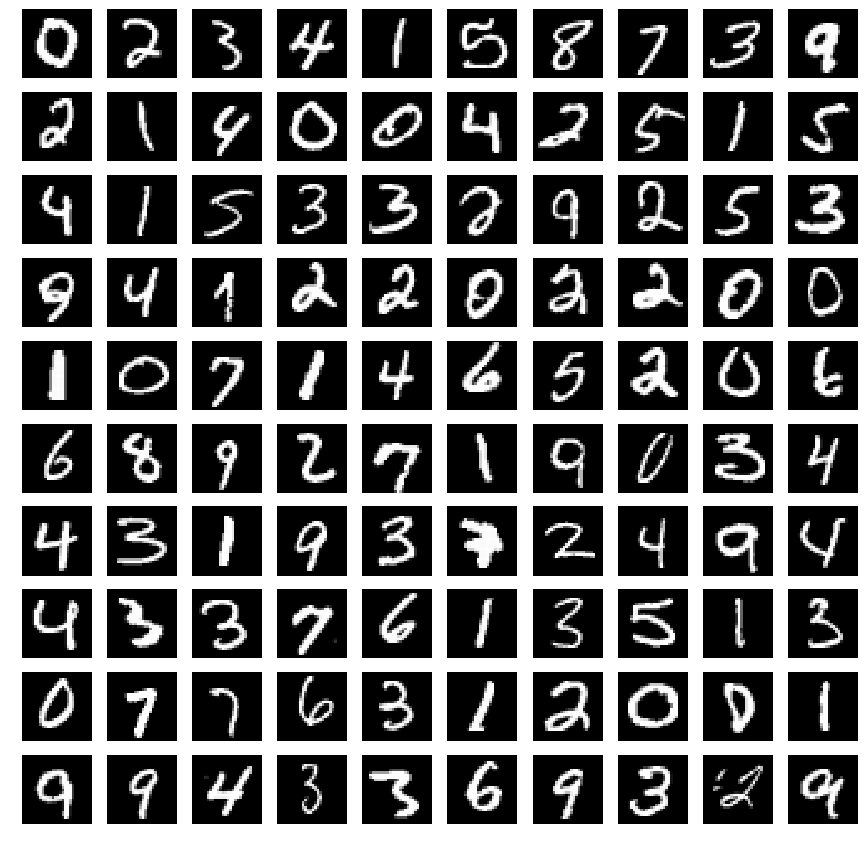

In [3]:
# show random 100 images
idx = np.random.permutation(len(train_batch))
train_batch = train_batch[idx]
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

In [301]:
# import all of the needed layers and activation layer
# ======= Activation Function  ==========
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)
def tf_tanh(x): return tf.tanh(x)
def d_tf_tanh(x): return 1.0 - tf_tanh(x) ** 2
def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))
# ======= Activation Function  ==========

class CNN():

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME',l2_reg = False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))

        return grad_pass,update_w

class FNN():
    """Fully Connected Neural Network Implemented in Tensorflow

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.
    special_init : type
        Description of parameter `special_init`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float64,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None,l2_regularization=False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        if l2_regularization:
            grad = grad + lamda * self.w

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w    

class FastICA_Layer():
    """Performs ICA via FastICA method

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    sym_decorrelation : type
        Description of attribute `sym_decorrelation`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,matrix : type
        Description of attribute `self,matrix`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.05,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act

    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)

    def getw(self): return self.w

    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass = tf.matmul(tf.transpose(self.w),self.layerA)
        
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA[:,tf.newaxis] * self.w
        grad = self.sym_decorrelation(grad_w)
        
        update_w = []
        
        # ==== Correct Method of Weight Update ====
#         update_w.append(tf.assign(self.w,grad))
        
        # ==== Wrong (gradient ascent) Method of Weight Update ====
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        
        return grad_pass,update_w
    
class ICA_Layer():
    """Perform Independent component analysis via gradient ascent method
    see: http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_ICA09.pdf

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,input : type
        Description of attribute `self,input`.
    act
    d_act

    """

    def __init__(self,inc,act,d_act):
        self.w = tf.Variable(tf.random_normal([inc,inc],stddev=0.05,seed=2,dtype=tf.float64))
        self.m = tf.Variable(tf.zeros_like(self.w));self.v = tf.Variable(tf.zeros_like(self.w));
        self.act = act; self.d_act = d_act
    def getw(self): return self.w
    
    def feedforward(self,input):
        self.input = input
        self.ica_est = tf.matmul(input,self.w)
        self.ica_est_act = self.act(self.ica_est)
        return self.ica_est_act

    def backprop_ica(self):
        grad_part_2 = self.d_act(self.ica_est)
        grad_part_3 = self.input

        grad_pass = tf.matmul(grad_part_2,tf.transpose(self.w))
        grad_sum_1 = tf.expand_dims(tf.reduce_sum(tf.transpose(self.input),1),1) / batch_size
        grad_sum_2 = tf.expand_dims(tf.reduce_sum(self.ica_est_act,0),0) / batch_size
        grad = tf.linalg.inv(tf.transpose(self.w)) - (2.0/batch_size) * tf.matmul(grad_sum_1,grad_sum_2)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,self.w+adam_middle))
        return grad_pass,update_w
    
    def backprop(self,gradient=None):
        grad_part_1 = tf.transpose(gradient)
        grad_part_2 = self.d_act(self.ica_est)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w  


In [317]:
# define hyper, class and graph
num_epcoch = 2000 ; learning_rate = 0.00000001; print_size = 100
batch_size = 50
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN(1,1,1)
l2 = CNN(1,1,1)
# l_fast_ica = FastICA_Layer(batch_size,batch_size,act=tf_logcosh,d_act=d_tf_logcosh)
l_fast_ica = ICA_Layer(batch_size,act=tf_tanh,d_act=d_tf_tanh)

x = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float64)
# layer1 = l1.feedforward(x)
# layer2 = l2.feedforward(layer1)
layer2_flat = tf.reshape(x,[batch_size,-1])
layer_ica = l_fast_ica.feedforward(tf.transpose(layer2_flat))

ica_mean = tf.reduce_mean(layer_ica)

grad_ica,grad_ica_u = l_fast_ica.backprop_ica()
# grad_ica_reshape_ica = tf.reshape(grad_ica,[batch_size,28,28,1])
# grad_2_ica,grad_2_up_ica = l2.backprop(grad_ica_reshape_ica)
# grad_1_ica,grad_1_up_ica = l1.backprop(grad_2_ica)
# grad_update_ica = grad_ica_u + grad_2_up_ica + grad_1_up_ica
grad_update_ica = grad_ica_u

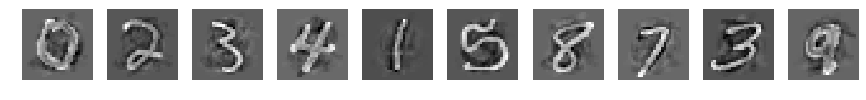

iter:  100  index:  0  mean  -2.4844084562861086e-05
------------
iter:  200  index:  0  mean  -2.4843600259654888e-05
------------
iter:  300  index:  0  mean  -2.4843228414676803e-05
------------
iter:  400  index:  0  mean  -2.4842893840000087e-05
------------
iter:  500  index:  0  mean  -2.484258079225635e-055
------------
iter:  600  index:  0  mean  -2.4842288912726554e-05
------------
iter:  700  index:  0  mean  -2.4842018962742862e-05
------------
iter:  800  index:  0  mean  -2.4841760979784325e-05
------------
iter:  900  index:  0  mean  -2.4841521152179335e-05
------------
iter:  1000  index:  0  mean  -2.4841295010562123e-05
------------
iter:  1100  index:  0  mean  -2.484107998187682e-055
------------
iter:  1200  index:  0  mean  -2.484087251995716e-055
------------
iter:  1300  index:  0  mean  -2.4840668517016063e-05
------------
iter:  1400  index:  0  mean  -2.484046398291326e-055
------------
iter:  1500  index:  0  mean  -2.484025550389921e-055
------------
iter

In [318]:
# start the interactive session

def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert(X.ndim == 2)
    EPS = 1e-5

    #   covariance matrix
    cov = np.dot(X.T, X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = np.linalg.eigh(cov)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1. / np.sqrt(d + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(E, D), E.T)

    X_white = np.dot(X, W)

    return X_white

# train_batch_save = train_batch.copy()
train_batch = train_batch_save[:batch_size,:,:,:]
train_batch = zca_whiten(train_batch.reshape(batch_size,-1).T).T.reshape(batch_size,28,28,1)
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for iter in range(num_epcoch):
    for current_batch_index in range(0,len(train_batch),batch_size):
        current_data = train_batch[current_batch_index:current_batch_index+batch_size]
        sess_results = sess.run([ica_mean,grad_update_ica],feed_dict={x:current_data})
        print('iter: ',iter,' index: ', current_batch_index,' mean ',sess_results[0],end="\r")
    if iter > 0 and iter % print_size == 0 :
        print('\n------------')

In [319]:
# get the ICA data as well as other layers
final_sess_results = sess.run([layer_ica],feed_dict={x:current_data})
for samples in final_sess_results:
    print(samples.shape)
data_ica = final_sess_results[0].T.reshape(batch_size,28,28)
all_data = [data_ica]

(784, 50)


In [320]:
# normalized the data 
for norm in all_data:
    norm[:,:,:] = (norm[:,:,:]-norm[:,:,:].min())/(norm[:,:,:].max()-norm[:,:,:].min())

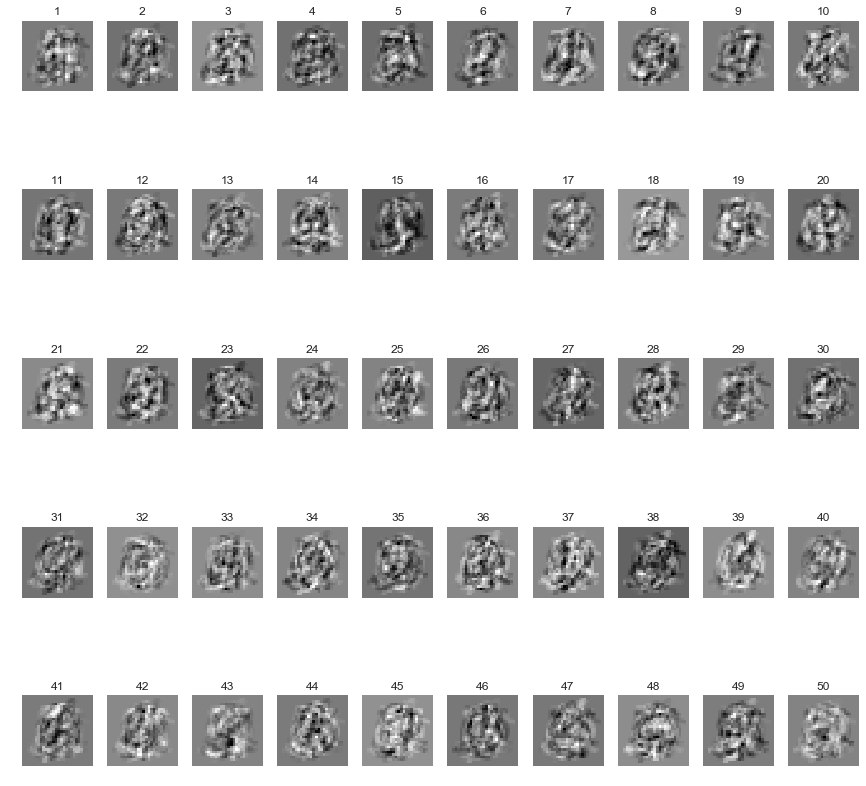

-------------------


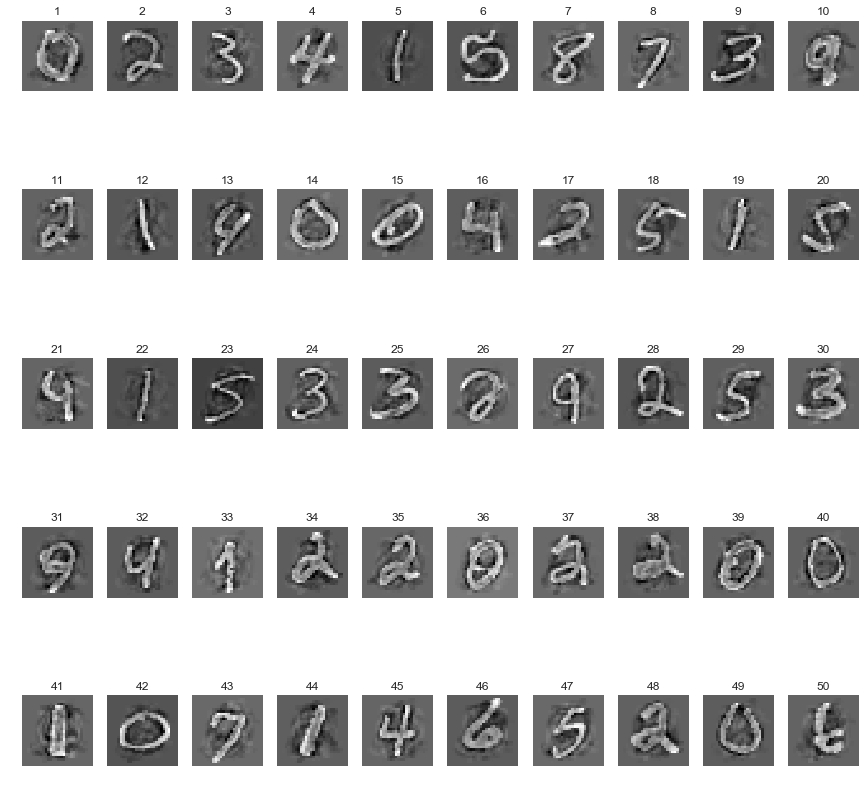

In [321]:
# view each of the data
for final_data in all_data:
    fig=plt.figure(figsize=(15, 15))
    columns = 10;rows = 5
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        try:
            plt.imshow(np.squeeze(final_data[i-1]),cmap='gray')
        except:
            pass
        plt.axis('off')
        plt.title(str(i))
    plt.show()
    print('-------------------')
    
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()

In [257]:
from sklearn.decomposition import FastICA

temp_data = train_batch_save[:batch_size,:,:,:]
sk_ica = FastICA(n_components=batch_size,max_iter=1000000)
sk_ica_data = sk_ica.fit_transform(temp_data.reshape(batch_size,-1).T).T
print(sk_ica_data.shape)
sk_re = sk_ica_data.reshape(batch_size,28,28)
sk_re[:,:,:] = (sk_re[:,:,:]-sk_re[:,:,:].min())/(sk_re[:,:,:].max()-sk_re[:,:,:].min())

(50, 784)


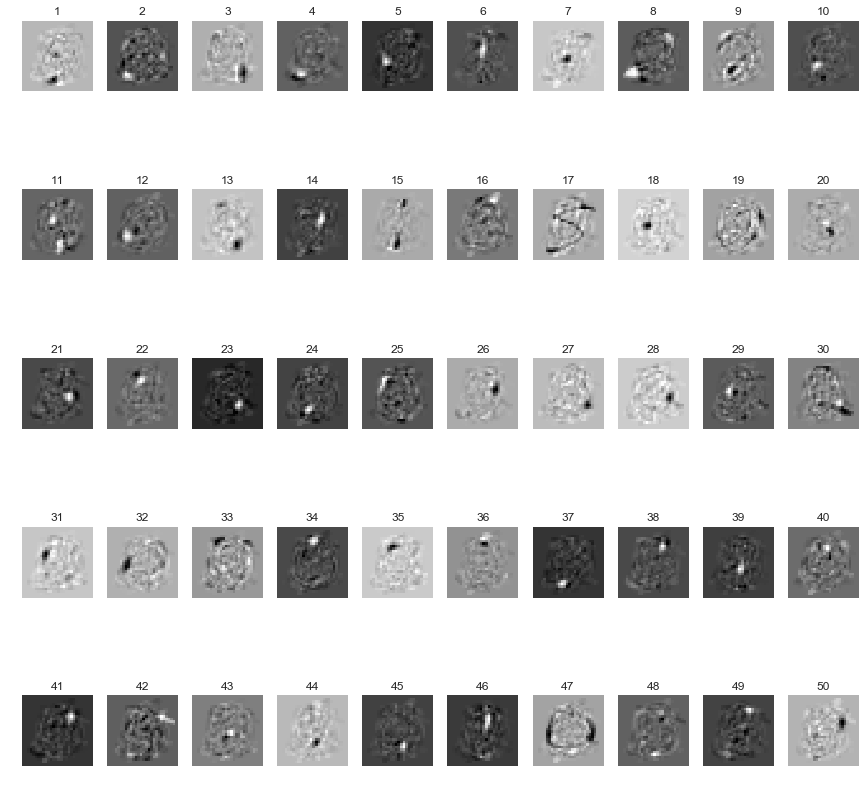

In [258]:
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(sk_re[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()

In [124]:
! git all-go

[master 6c9db65e] s
 2 files changed, 1410 insertions(+), 938 deletions(-)
 rewrite Understanding_Concepts/deep_ica/.ipynb_checkpoints/b smaller-checkpoint.ipynb (70%)


The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   d0f1892e..6c9db65e  master -> master
